## K-Nearest-Neighbors

KNN falls in the supervised learning family of algorithms. Informally, this means that we are given a labelled dataset consiting of training observations (x,y) and would like to capture the relationship between x and y. More formally, our goal is to learn a function h:X→Y so that given an unseen observation x, h(x) can confidently predict the corresponding output y.

In this module we will explore the inner workings of KNN, choosing the optimal K values and using KNN from scikit-learn.

## Problem statement

### Dataset

The data set we’ll be using is the Iris Flower Dataset which was first introduced in 1936 by the famous statistician Ronald Fisher and consists of 50 observations from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals.

**Source:** https://archive.ics.uci.edu/ml/datasets/Iris

**Train the KNN algorithm to be able to distinguish the species from one another given the measurements of the 4 features.**

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import pydotplus
from IPython.display import Image  
import graphviz



#### Read the iris.csv file

In [2]:
data = pd.read_csv('iris.csv')
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
data.shape
# 152 rows and 6 columns

(152, 6)

In [4]:
data.info()
# float64(4), int64(1), object(1)
# nan values exists

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             152 non-null    int64  
 1   SepalLengthCm  151 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   151 non-null    float64
 5   Species        152 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [5]:
data.describe(include='all')
# 5 point summary

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,152.000000,151.000000,150.000000,150.000000,151.000000,152
unique,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,Iris-virginica
freq,NaN,NaN,NaN,NaN,NaN,52
mean,76.500000,5.843709,3.054000,3.758667,1.202649,NaN
std,44.022721,0.825314,0.433594,1.764420,0.762185,NaN
min,1.000000,4.300000,2.000000,1.000000,0.100000,NaN
25%,38.750000,5.100000,2.800000,1.600000,0.300000,NaN
50%,76.500000,5.800000,3.000000,4.350000,1.300000,NaN
75%,114.250000,6.400000,3.300000,5.100000,1.800000,NaN


In [6]:
data.drop('Id', axis = 1, inplace = True)
# Id will not contribute to model

## Data Pre-processing

## Estimating missing values

*Its not good to remove the records having missing values all the time. We may end up loosing some data points. So, we will have to see how to replace those missing values with some estimated values (median) *

In [7]:
data.isnull().sum() / len(data) * 100
# missing values found

SepalLengthCm    0.657895
SepalWidthCm     1.315789
PetalLengthCm    1.315789
PetalWidthCm     0.657895
Species          0.000000
dtype: float64

In [8]:
# median imputation
data['SepalLengthCm'] = data['SepalLengthCm'].fillna(data['SepalLengthCm'].median())
data['SepalWidthCm'] = data['SepalWidthCm'].fillna(data['SepalWidthCm'].median())
data['PetalLengthCm'] = data['PetalLengthCm'].fillna(data['PetalLengthCm'].median())
data['PetalWidthCm'] = data['PetalWidthCm'].fillna(data['PetalWidthCm'].median())

In [9]:
data.isnull().sum()
# null values treated

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

## Dealing with categorical data

Change all the classes to numericals (0to2).

In [10]:
data['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [11]:
from sklearn.preprocessing import OrdinalEncoder
ode = OrdinalEncoder(categories=[['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']])
enc_data = ode.fit_transform(data['Species'].values.reshape(-1,1))

In [12]:
data['Species'] = enc_data.astype('int')

In [13]:
data['Species'].unique()

array([0, 1, 2])

## Observe the association of each independent variable with target variable and drop variables from feature set having correlation in range -0.1 to 0.1 with target variable.*

In [14]:
data.corr()
# no independant features ranging from -0.1 to 0.1

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
SepalLengthCm,1.000000,-0.109369,0.871120,0.815986,0.775061
SepalWidthCm,-0.109369,1.000000,-0.420713,-0.356510,-0.417318
PetalLengthCm,0.871120,-0.420713,1.000000,0.962043,0.944477
PetalWidthCm,0.815986,-0.356510,0.962043,1.000000,0.952513
Species,0.775061,-0.417318,0.944477,0.952513,1.000000


## Observe the independent variables variance and drop such variables having no variance or almost zero variance(variance < 0.1). They will be having almost no influence on the classification.*

In [15]:
data.var()
# no features have variance < 0.1

SepalLengthCm    0.676645
SepalWidthCm     0.185552
PetalLengthCm    3.076516
PetalWidthCm     0.577141
Species          0.675322
dtype: float64

## Plot the scatter matrix for all the variables.*

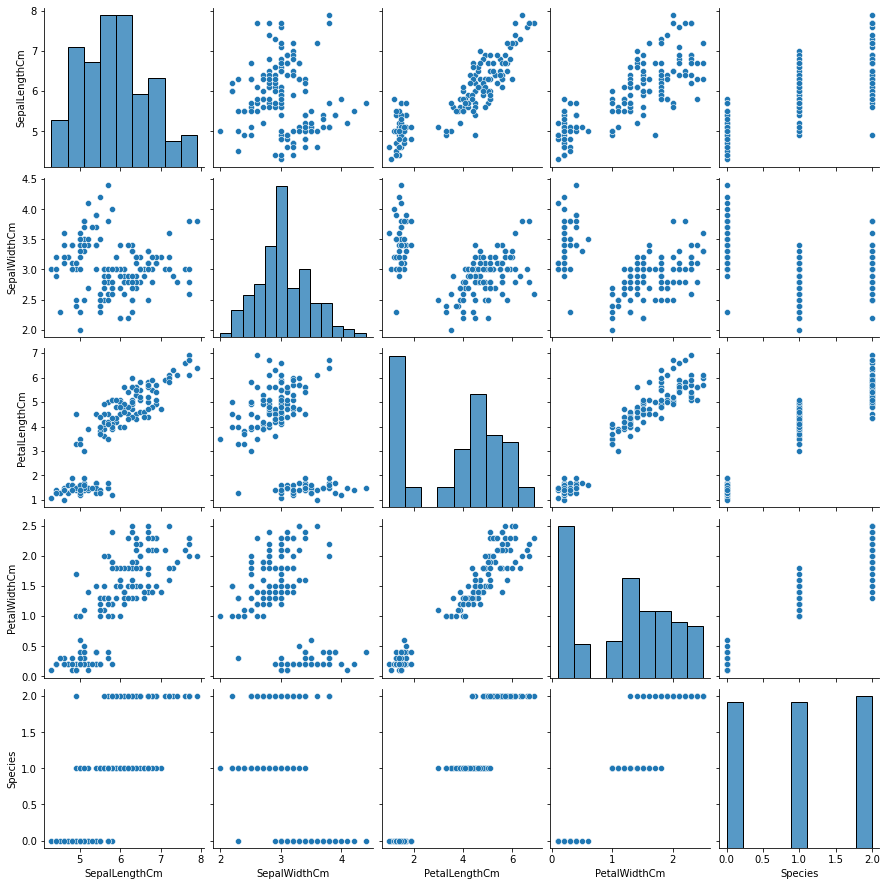

In [16]:
sns.pairplot(data)

## Split the dataset into training and test sets

*Split the dataset into training and test sets with 80-20 ratio.*

In [17]:
# scaling
sc = StandardScaler()
for i in data.drop('Species', axis = 1):
    data[i] = sc.fit_transform(data[i].values.reshape(-1,1))
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,-0.90675,1.040463,-1.353632,-1.325008,0
1,-1.15069,-0.124120,-1.353632,-1.325008,0
2,-1.39463,0.341713,-1.410833,-1.325008,0
3,-1.51660,0.108797,-1.296431,-1.325008,0
4,-1.02872,1.273380,-1.353632,-1.325008,0


In [18]:
x = data.drop('Species', axis = 1)
y = data['Species']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Build the model and train and test on training and test sets respectively using **scikit-learn**. Print the Accuracy of the model with different values of **k=3,5,9**.*

In [19]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(x_train, y_train)
y_pred1 = knn3.predict(x_test)
print('accuracy for k=3 : ', accuracy_score(y_test, y_pred1))

knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(x_train, y_train)
y_pred2 = knn5.predict(x_test)
print('accuracy for k=5 : ', accuracy_score(y_test, y_pred2))

knn9 = KNeighborsClassifier(n_neighbors=9)
knn9.fit(x_train, y_train)
y_pred3 = knn9.predict(x_test)
print('accuracy for k=9 : ', accuracy_score(y_test, y_pred3))

accuracy for k=3 :  1.0
accuracy for k=5 :  1.0
accuracy for k=9 :  0.967741935483871


## Cross Validation

In [20]:
parameters = {'n_neighbors': range(1,20,2)}

knn = KNeighborsClassifier()

tree1 = GridSearchCV(knn, param_grid=parameters, cv = 3, scoring = 'accuracy')
tree1.fit(x_train, y_train)
tree1.best_params_

{'n_neighbors': 5}

In [21]:
mse = []
for i in range(1,20,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    mse.append(1-accuracy)
err = pd.DataFrame({'k':range(1,20,2),'MSE':mse})
err
# k=9 and k=11 has low mse

,k,MSE
0,1,0.000000
1,3,0.000000
2,5,0.000000
3,7,0.000000
4,9,0.032258
5,11,0.032258
6,13,0.000000
7,15,0.000000
8,17,0.000000
9,19,0.000000


## Plot misclassification error vs k (with k value on X-axis) using matplotlib.*

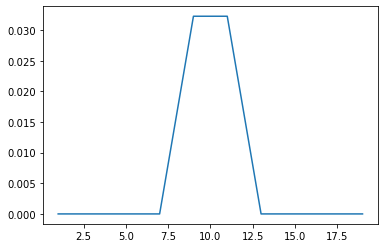

In [22]:
plt.plot(err['k'],err['MSE'])

# Naive Bayes

###  Import Iris.csv

In [23]:
data.head()
# iris dataset imported already -- refer above

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,-0.90675,1.040463,-1.353632,-1.325008,0
1,-1.15069,-0.124120,-1.353632,-1.325008,0
2,-1.39463,0.341713,-1.410833,-1.325008,0
3,-1.51660,0.108797,-1.296431,-1.325008,0
4,-1.02872,1.273380,-1.353632,-1.325008,0


#### Slice data set for Independent variables and dependent variables
#### Please note 'Species' is my dependent variables, name it y and independent set data as X

In [24]:
x = data.drop('Species', axis = 1)
y = data['Species']

#### Find the distribution of target variable (Class)
#### And, Plot the distribution of target variable using histogram

In [25]:
# class distribution of target variable
data['Species'].value_counts()

2    52
1    50
0    50
Name: Species, dtype: int64

### Plot the distribution of target variable using histogram

<AxesSubplot:ylabel='Frequency'>

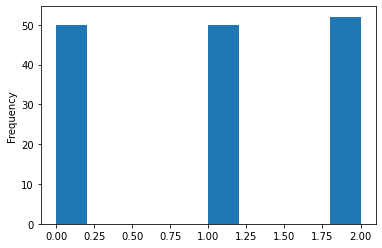

In [26]:
data['Species'].plot(kind='hist')

### Plot Scatter Matrix to understand the distribution of variables and give insights from it

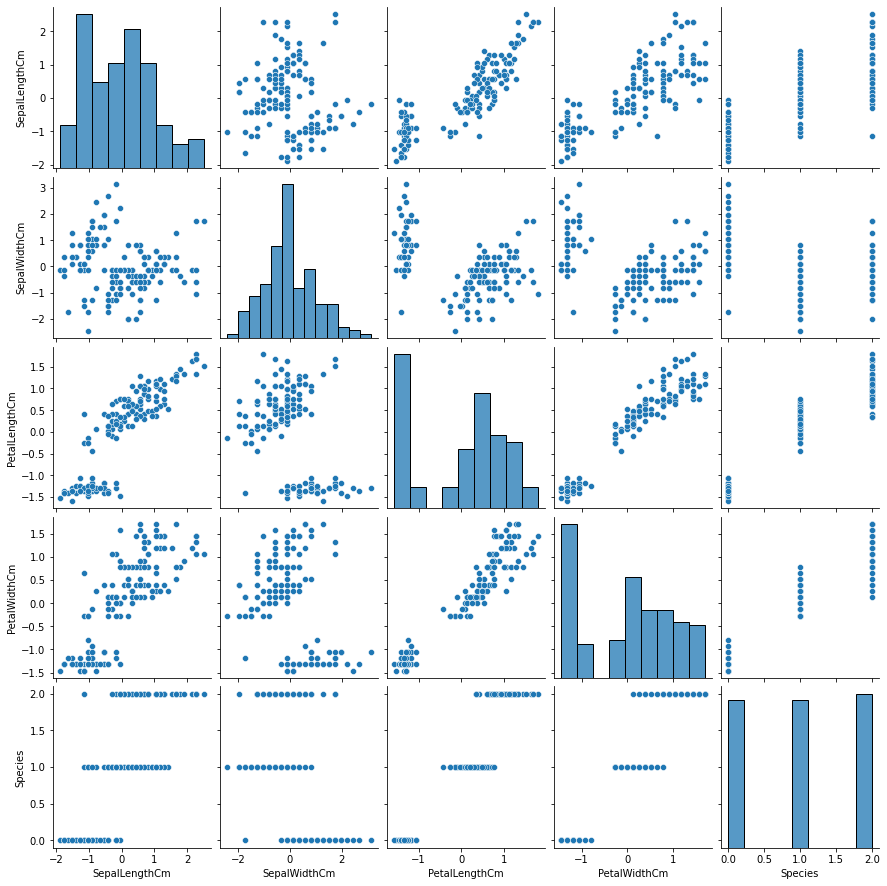

In [27]:
sns.pairplot(data)

#### Find Correlation among all variables and give your insights 

In [28]:
data.corr()
# PetalLengthCm & Species, PetalWidthCm & Species are highly correlated

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
SepalLengthCm,1.000000,-0.109369,0.871120,0.815986,0.775061
SepalWidthCm,-0.109369,1.000000,-0.420713,-0.356510,-0.417318
PetalLengthCm,0.871120,-0.420713,1.000000,0.962043,0.944477
PetalWidthCm,0.815986,-0.356510,0.962043,1.000000,0.952513
Species,0.775061,-0.417318,0.944477,0.952513,1.000000


#### Split data in Training and Validation in 80:20

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

#### Do Feature Scaling 

In [30]:
# scaling already done -- refer above

# sc = StandardScaler()
# for i in data.drop('Species', axis = 1):
#     data[i] = sc.fit_transform(data[i].values.reshape(-1,1))
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,-0.90675,1.040463,-1.353632,-1.325008,0
1,-1.15069,-0.124120,-1.353632,-1.325008,0
2,-1.39463,0.341713,-1.410833,-1.325008,0
3,-1.51660,0.108797,-1.296431,-1.325008,0
4,-1.02872,1.273380,-1.353632,-1.325008,0


#### Train and Fit NaiveBayes Model

In [31]:
nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

#### Print Accuracy and Confusion Matrix and Conclude your findings

In [32]:
accuracy_score(y_test, y_pred)
# accuracy is 1

1.0

In [33]:
confusion_matrix(y_test, y_pred)

array([[10,  0,  0],
       [ 0, 13,  0],
       [ 0,  0,  8]], dtype=int64)

# SVM

This dataset describes the medical records for Pima Indians and whether or not each patient will have an onset of diabetes within ve years.

Fields description follow:

preg = Number of times pregnant

plas = Plasma glucose concentration a 2 hours in an oral glucose tolerance test

pres = Diastolic blood pressure (mm Hg)

skin = Triceps skin fold thickness (mm)

test = 2-Hour serum insulin (mu U/ml)

mass = Body mass index (weight in kg/(height in m)^2)

pedi = Diabetes pedigree function

age = Age (years)

class = Class variable (1:tested positive for diabetes, 0: tested negative for diabetes)

#### Read the input file 'Diabetes.csv' using Pandas and check it's column names

In [34]:
data = pd.read_csv('pima-indians-diabetes.csv')
data.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### Check the dimensions of dataset

In [35]:
data.shape
# 768 rows and 9 columns

(768, 9)

#### Check distribution of dependent variable 'class' and plot it

In [36]:
data['class'].value_counts()

# Out of  768 data points, 500 are labeled as 0 and 268 as 1.
# Class 0 means No diabetes, outcome 1 means diabetes

0    500
1    268
Name: class, dtype: int64

<AxesSubplot:>

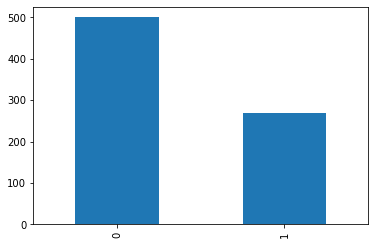

In [37]:
data['class'].value_counts().plot(kind='bar')

#### Do correlation analysis and bivariate viualization with Insights

In [38]:
data.corr()
# correlation analysis

,preg,plas,pres,skin,test,mass,pedi,age,class
preg,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
plas,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
pres,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
skin,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
test,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
mass,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedi,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
class,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


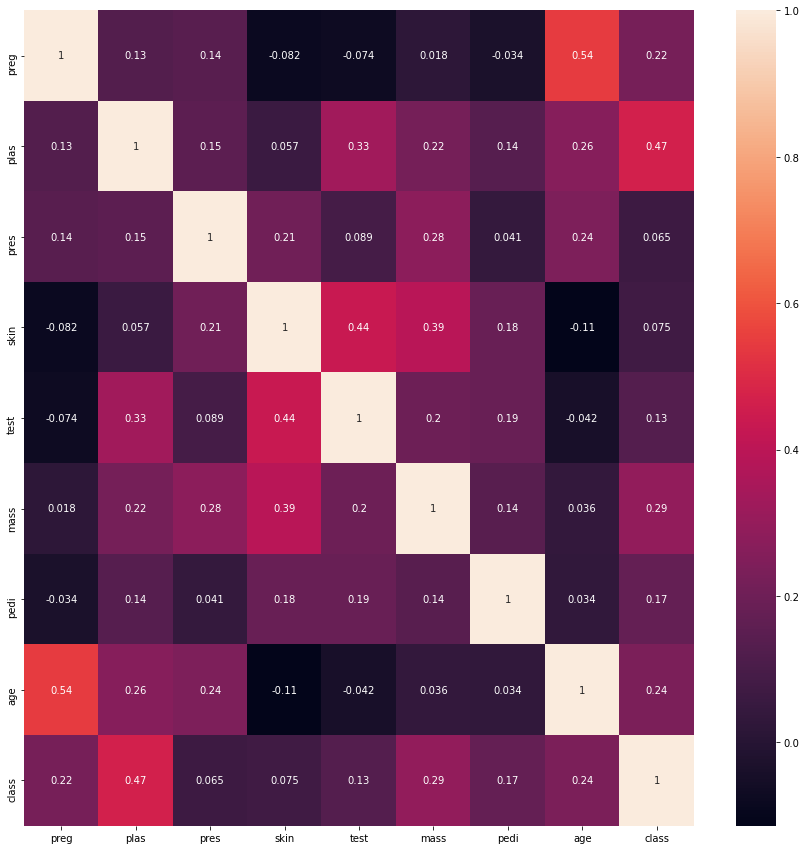

In [39]:
plt.figure(figsize = (15,15))
sns.heatmap(data.corr(), annot=True)
plt.show()

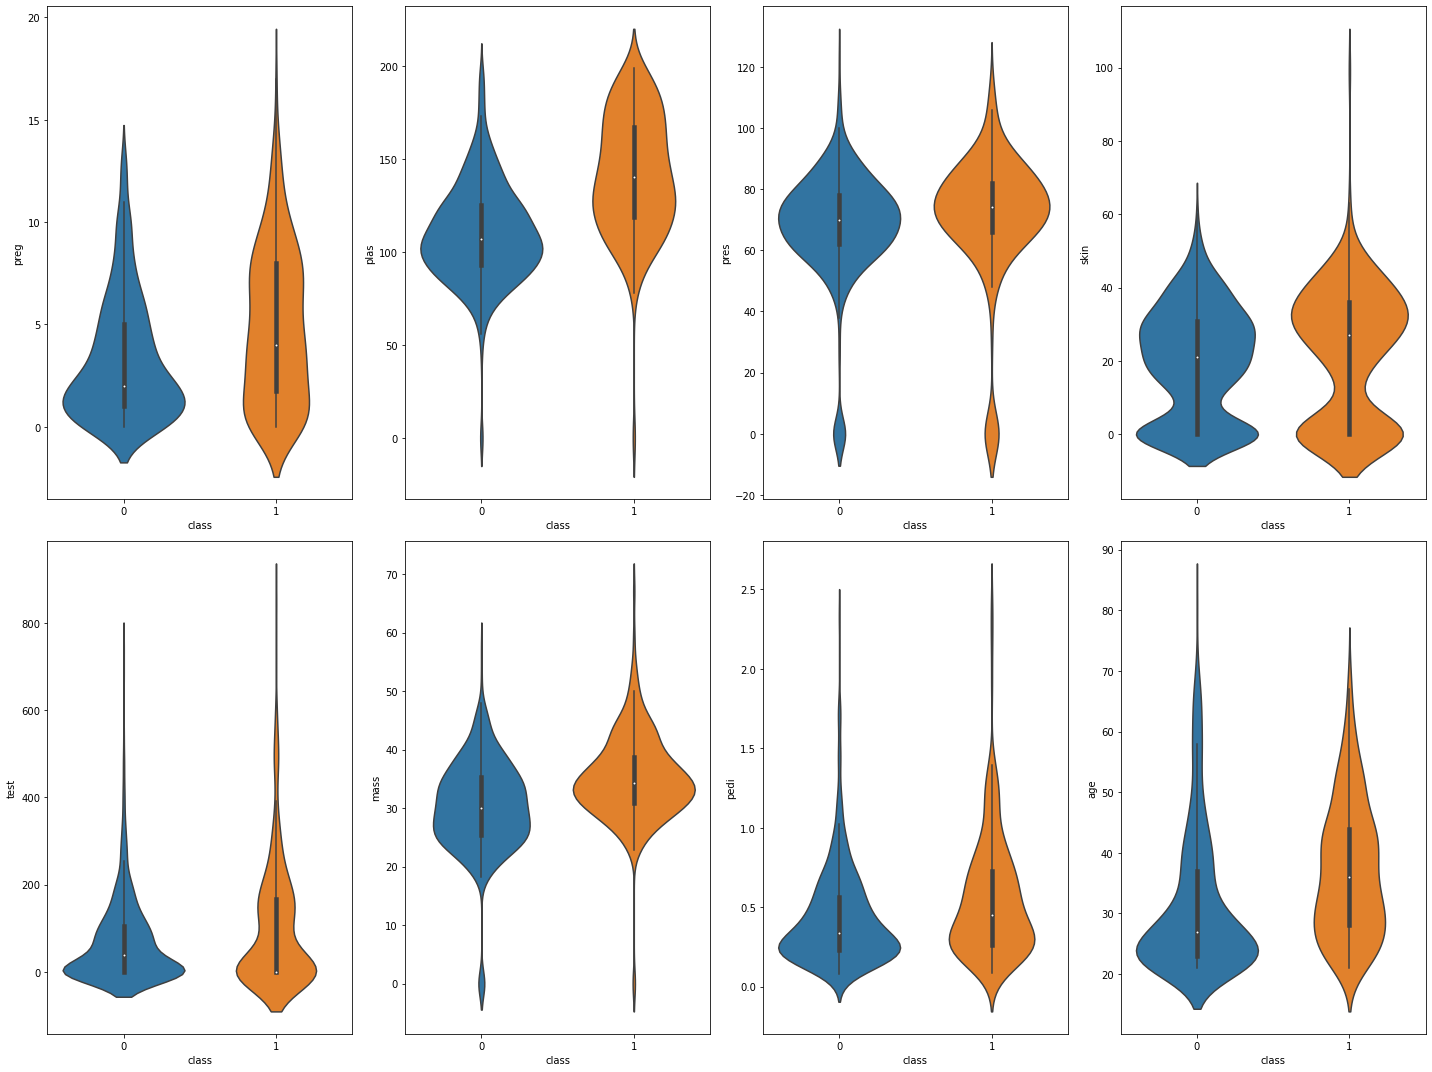

In [40]:
# bivariate analysis
row, col, count = 2,4,1
plt.figure(figsize = (20,15))
for i in data.drop('class', axis = 1):
    plt.subplot(row, col, count)
    sns.violinplot(data['class'], data[i])
    count+=1
plt.tight_layout()
plt.show()

#### Do train and test split with stratify sampling on Outcome variable to maintain the distribution of dependent variable

In [41]:
x = data.drop('class', axis = 1)
y = data['class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

#### Train Support Vector Machine Model

In [42]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(x_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(x_test, y_test)))

#The model overfits substantially with a perfect score on the training set and only 65% accuracy on the test set.
#SVM requires all the features to be on a similar scale. We will need to rescale our data that all the features are approximately on the same scale and than see the performance

Accuracy on training set: 0.76
Accuracy on test set: 0.79


#### Scale the data points using MinMaxScaler

In [43]:
mm = MinMaxScaler()
for i in x:
    x[i] = mm.fit_transform(x[i].values.reshape(-1,1))
x.head()

,preg,plas,pres,skin,test,mass,pedi,age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000


#### Fit SVM Model on scaled data and give your observation

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

svc = SVC()
svc.fit(x_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(x_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(x_test, y_test)))

Accuracy on training set: 0.80
Accuracy on test set: 0.80


#### Try improving the model accuracy using C=1000

In [45]:
svc = SVC(C=1000)
svc.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(svc.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(x_test, y_test)))

Accuracy on training set: 0.945
Accuracy on test set: 0.760
